In [1]:
import glob
import json
import cv2
import numpy as np
from typing import List
import torch
import sys
from torchreid.utils import FeatureExtractor
from dataclasses import dataclass
from pathlib import Path
from zipfile import ZipFile
import shutil
from scipy import spatial
from tqdm import tqdm
import matplotlib.pyplot as plt
import tkinter
import matplotlib

In [2]:
matplotlib.use('TkAgg')

In [3]:
torch.cuda.is_available()

True

In [4]:
model_path_0 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x1_0_imagenet.pth'
model_path_1 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_ain_x1_0_msmt17_256x128_amsgrad_ep50_lr0.0015_coslr_b64_fb10_softmax_labsmth_flip_jitter.pth'
model_path_2 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_ain_x1_0_market1501_256x128_amsgrad_ep100_lr0.0015_coslr_b64_fb10_softmax_labsmth_flip_jitter.pth'
model_path_3 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_ain_x1_0_dukemtmcreid_256x128_amsgrad_ep90_lr0.0015_coslr_b64_fb10_softmax_labsmth_flip_jitter.pth'
model_path_4 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x0_5_market_256x128_amsgrad_ep180_stp80_lr0.003_b128_fb10_softmax_labelsmooth_flip.pth'
model_path_5 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x0_25_market_256x128_amsgrad_ep180_stp80_lr0.003_b128_fb10_softmax_labelsmooth_flip.pth'
model_path_6 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x0_75_market_256x128_amsgrad_ep150_stp60_lr0.0015_b64_fb10_softmax_labelsmooth_flip.pth'
model_path_7 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x1_0_market_256x128_amsgrad_ep150_stp60_lr0.0015_b64_fb10_softmax_labelsmooth_flip.pth.pth'
extractor = FeatureExtractor(
    model_name = 'osnet_x1_0',
    model_path = model_path_0,
    device='cuda'
)

Successfully loaded imagenet pretrained weights from "/home/eam/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


/home/eam/anaconda3/envs/alphapose_yolo4/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [15]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5l', force_reload=False)  # or yolov5m, yolov5l, yolov5x, yolov5x6, custom

Using cache found in /home/eam/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-11-7 torch 1.9.0 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 3914MiB)

Fusing layers... 
Model Summary: 367 layers, 46533693 parameters, 0 gradients
Adding AutoShape... 


In [11]:
def crop(img, bboxes):
    cropped_imgs = []
    for bbox in bboxes:
        bbox = [x for x in bbox]
        cropped = img[bbox[1]:bbox[3], bbox[0]: bbox[2]]
        cropped_imgs.append(cropped)
    return cropped_imgs

In [12]:
frame = "extracted_rs/frames/02181.jpg"
result = model(frame, size=1280)

NameError: name 'model' is not defined

In [8]:
detections = [det.to(torch.int) for det in result.pred[0] if det[5] == 0.0 and det[4] > 0.55] 
detections = [x.clone().detach().cpu().numpy() for x in detections]

In [9]:
detections[0][0:2]

array([178, 111], dtype=int32)

In [10]:
orig_f = cv2.imread(frame)
f = orig_f.copy()
for det in detections:
    f = cv2.rectangle(f, det[0:2], det[2:4], color=(0,255,0), thickness=1)

In [11]:
cv2.imshow("bbox", f)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [12]:
croppedImages = crop(orig_f, detections)
cnt = 0
for img in croppedImages:
    cv2.imshow(f"bbox{cnt}", img)
    cnt += 1
cv2.waitKey(0)
cv2.destroyAllWindows()

In [13]:
cv2.imwrite("p1.jpg", croppedImages[0])
cv2.imwrite("p2.jpg", croppedImages[1])

IndexError: list index out of range

In [14]:
features1 = extractor(croppedImages[0])
np_features1 = features1.squeeze().cpu().detach().numpy().astype(float)

features2 = extractor(croppedImages[1])
np_features2 = features2.squeeze().cpu().detach().numpy().astype(float)

spatial.distance.cosine(np_features1, np_features2)

IndexError: list index out of range

model_path_0 => distance: 0.2962988306451111
model_path_1 => distance: 0.18403908676943825
model_path_2 => distance: 0.17466252157291695
model_path_3 => distance: 0.16428339139972314
model_path_4 => distance: 0.15251915558406182
model_path_5 => distance: 0.14163562124834916
model_path_6 => distance: 0.22081072380148614
model_path_7 => distance: 0.2962988306451111

### Consider History of objects

In [17]:
def show_frame(title, frame):
    cv2.imshow("frame", frame)
    cv2.setWindowTitle("frame", title)

In [18]:
frames_folder_path = "extracted_rs/frames/*"
frames_path = sorted(glob.glob(frames_folder_path))
start_frame = 2098
end_frame = 2433
tracklet_indices1 = {}
dataset = range(start_frame, end_frame)
frame_num = start_frame
finish = False

while frame_num in dataset:
    img_name = f"0{frame_num}.jpg"
    frame_path = f"extracted_rs/frames/{img_name}"
    frame = cv2.imread(frame_path)
    
    result = model(frame)
    detections = [det.to(torch.int) for det in result.pred[0] if det[5] == 0.0 and det[4] > 0.55] 
    detections = [x.clone().detach().cpu().numpy() for x in detections]
    
#     croppedImages = crop(frame, detections)
#     for cImg in croppedImages:
#         features = extractor(cImg)
#         np_features = features.squeeze().cpu().detach().numpy().astype(float)
        
        
    track_index = 0
    print_cnt = 0
    while track_index < len(detections):
        f = frame.copy()
        det = detections[track_index]
        f = cv2.rectangle(f, det[0:2], det[2:4], color=(0,255,0), thickness=1)
        show_frame(img_name, f)
        k = cv2.waitKey(0)
        if k == 82: # up arrow
            track_index += 1
            track_index = min(track_index, len(detections) - 1)
            continue
        elif k == 84: # down arrow
            track_index -= 1
            track_index = max(track_index, 0)
            continue
        elif k == 13: # enter
            tracklet_indices1[img_name] = track_index
            print(img_name, track_index)
            print_cnt +=1
            if print_cnt > 10:
                clear_output(wait=True)
                print_cnt = 0
            frame_num += 1
            frame_num = min(frame_num, end_frame)
            break
        elif k == 32: # space
            tracklet_indices1[img_name] = -1
            print(img_name, -1)
            print_cnt +=1
            if print_cnt > 10:
                clear_output(wait=True)
                print_cnt = 0
            frame_num += 1
            frame_num = min(frame_num, end_frame)
            break
        elif k == 83: # right arrow
            frame_num += 1
            frame_num = min(frame_num, end_frame)
            break
        elif k == 81: # left arrow
            frame_num -= 1
            frame_num = max(frame_num, start_frame)
            break
        elif k == 27:  # close on ESC key
            finish = True
            break
    cv2.destroyAllWindows()
    if finish:
        break
    print("frame_number: ", frame_num)
cv2.destroyAllWindows()

In [19]:
mahya_indices = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])
np.save("mahya_2098_2433.npy", mahya_indices)
mahya_indices

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 

In [20]:
mahya_indices_bool = mahya_indices.astype(bool)
mohamad_indices = (~mahya_indices_bool).astype(int)
np.save("mohamad_2098_2433.npy", mohamad_indices)
mohamad_indices

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 

In [21]:
model_0_dists = np.empty(shape=(0))

In [22]:
model_1_dists = np.empty(shape=(0))
model_2_dists = np.empty(shape=(0))
model_3_dists = np.empty(shape=(0))
model_4_dists = np.empty(shape=(0))
model_5_dists = np.empty(shape=(0))
model_6_dists = np.empty(shape=(0))
model_7_dists = np.empty(shape=(0))

In [23]:
all_frame_detections = []
for i, frame_num in tqdm(enumerate(dataset)):
    img_name = f"0{frame_num}.jpg"
    frame_path = f"extracted_rs/frames/{img_name}"
    frame = cv2.imread(frame_path)
    
    result = model(frame)
    detections = [det.to(torch.int) for det in result.pred[0] if det[5] == 0.0 and det[4] > 0.55] 
    detections = [x.clone().detach().cpu().numpy() for x in detections]
    all_frame_detections.append(detections)

335it [01:04,  5.19it/s]


In [44]:
model_path_0 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x1_0_imagenet.pth'
model_path_1 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_ain_x1_0_msmt17_256x128_amsgrad_ep50_lr0.0015_coslr_b64_fb10_softmax_labsmth_flip_jitter.pth'
model_path_2 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_ain_x1_0_market1501_256x128_amsgrad_ep100_lr0.0015_coslr_b64_fb10_softmax_labsmth_flip_jitter.pth'
model_path_3 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_ain_x1_0_dukemtmcreid_256x128_amsgrad_ep90_lr0.0015_coslr_b64_fb10_softmax_labsmth_flip_jitter.pth'
model_path_4 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x0_5_market_256x128_amsgrad_ep180_stp80_lr0.003_b128_fb10_softmax_labelsmooth_flip.pth'
model_path_5 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x0_25_market_256x128_amsgrad_ep180_stp80_lr0.003_b128_fb10_softmax_labelsmooth_flip.pth'
model_path_6 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x0_75_market_256x128_amsgrad_ep150_stp60_lr0.0015_b64_fb10_softmax_labelsmooth_flip.pth'
model_path_7 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x1_0_market_256x128_amsgrad_ep150_stp60_lr0.0015_b64_fb10_softmax_labelsmooth_flip.pth.pth'
extractor = FeatureExtractor(
    model_name = 'osnet_x1_0',
    model_path = model_path_0,
    device='cuda'
)

Successfully loaded imagenet pretrained weights from "/home/eam/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


In [45]:
mo_feats = np.empty(shape=(512,))
ma_feats = np.empty(shape=(512,))
for i, frame_num in tqdm(enumerate(dataset)):
    img_name = f"0{frame_num}.jpg"
    frame_path = f"extracted_rs/frames/{img_name}"
    frame = cv2.imread(frame_path)
    
    detections = all_frame_detections[i]
#     result = model(frame)
#     detections = [det.to(torch.int) for det in result.pred[0] if det[5] == 0.0 and det[4] > 0.55] 
#     detections = [x.clone().detach().cpu().numpy() for x in detections]
    
    
    croppedImages = crop(frame, detections)
    mohamad_cropped = croppedImages[mohamad_indices[i]]
    mahya_cropped = croppedImages[mahya_indices[i]]
    
    mo_features = extractor(mohamad_cropped)
    mo_np_features = mo_features.squeeze().cpu().detach().numpy().astype(float)
    mo_feats = np.vstack((mo_np_features, mo_feats))
    
    ma_features = extractor(mahya_cropped)
    ma_np_features = ma_features.squeeze().cpu().detach().numpy().astype(float)
    ma_feats = np.vstack((ma_np_features, ma_feats))

335it [00:10, 31.83it/s]


In [46]:

for row in tqdm(range(1, mo_feats.shape[0]-1)):
    dist = spatial.distance.cosine(mo_feats[0:row,:].mean(axis = 0), ma_feats[0:row,:].mean(axis=0))
    model_0_dists = np.hstack((dist, model_0_dists))

100%|███████████████████████████████████████| 334/334 [00:00<00:00, 5012.98it/s]


In [48]:
np.save("torchreid_1.npy", model_0_dists)

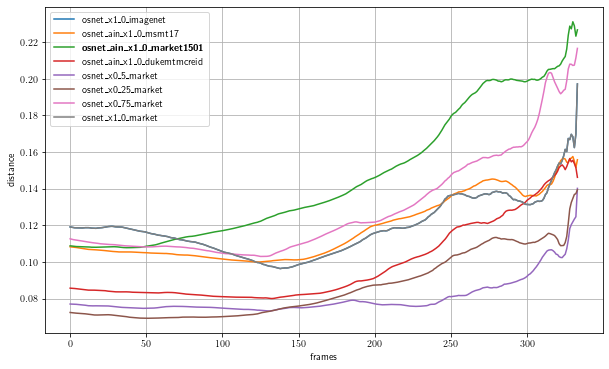

In [49]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)
# activate latex text rendering
plt.rc('text', usetex=True)
plt.plot(range(334), model_0_dists, label = "osnet\_x1\_0\_imagenet")
plt.plot(range(334), model_1_dists, label = "osnet\_ain\_x1\_0\_msmt17")
plt.plot(range(334), model_2_dists, label = r"\textbf{osnet\_ain\_x1\_0\_market1501}")
plt.plot(range(334), model_3_dists, label = "osnet\_ain\_x1\_0\_dukemtmcreid")
plt.plot(range(334), model_4_dists, label = "osnet\_x0\_5\_market")
plt.plot(range(334), model_5_dists, label = "osnet\_x0\_25\_market")
plt.plot(range(334), model_6_dists, label = "osnet\_x0\_75\_market")
plt.plot(range(334), model_7_dists, label = "osnet\_x1\_0\_market")
plt.xlabel("frames")
plt.ylabel("distance")
plt.grid()
plt.legend()
plt.savefig("visual_features_comparison.pdf", bbox_inches='tight')
plt.show()

In [4]:
model_0_dists

NameError: name 'model_0_dists' is not defined